In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import math
import json
from func import *

import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nameparser.parser import HumanName
from nltk.corpus import wordnet

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

pd.options.display.max_colwidth = 100
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
H = pd.read_csv('../data/Harmanpreet.tsv',delimiter='\t')
T = pd.read_csv('../data/Tristan.tsv',delimiter='\t')
Y = pd.read_csv('../data/Yan.tsv',delimiter='\t')
df = pd.concat([H,T,Y])
df = df[['Name', 'title','coding']]
df.index = range(0,len(df))
df = df[df['coding'].notna()]
df['coding'][df['coding']=='s'] = 'S'

## 1. Most frequent names appeared in the corpus

In [3]:
all_titles = [row.title for idx, row in df.iterrows()] 
all_titles = ' '.join(all_titles)

In [4]:
names = extract_entities(all_titles,'PERSON')
locations = extract_entities(all_titles,'GPE')

In [5]:
counter_n = Counter(names)
counter_n = Counter({k: c for k, c in counter_n.items() if c >= 3}) # appear more than 3 times
top_names = counter_n.most_common(100)

counter_l = Counter(locations)
counter_l = Counter({k: c for k, c in counter_l.items() if c >= 3}) # appear more than 3 times
top_locs = counter_l.most_common(100)

In [6]:
# top_names

In [7]:
# top_locs

In [8]:
# get rid of Trump and Biden
top_names1 = top_names[4:]

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


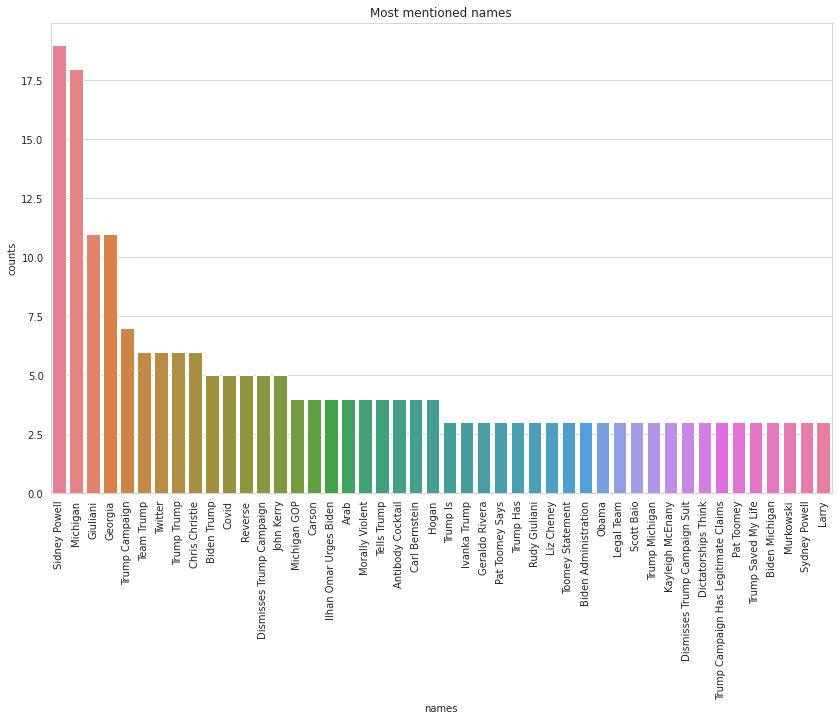

In [9]:
plot_top_names(top_names1, 'names')

In [10]:
# top_names1

/home/ubuntu/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


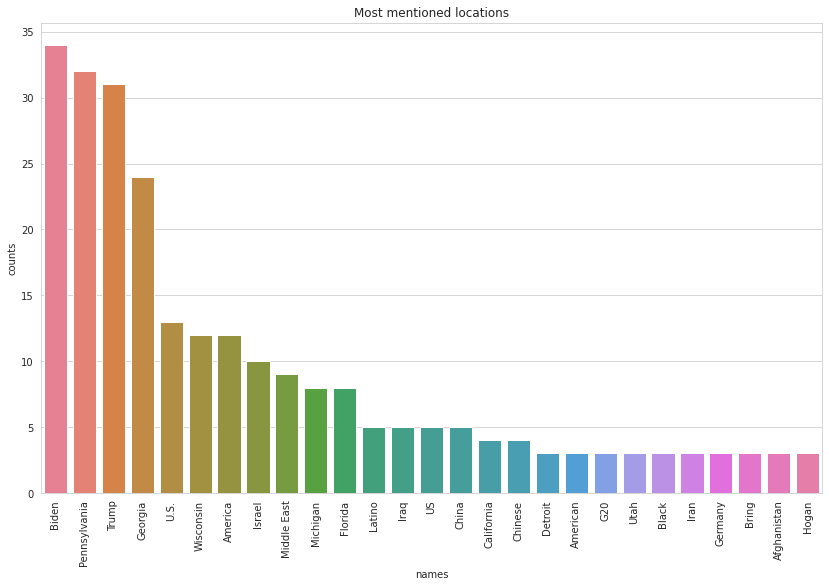

In [11]:
plot_top_names(top_locs, 'locations')

In [12]:
# manual filtering
top_names2 = ['Powell', 'Giuliani', 'Chris Christie', 'John Kerry', 'Carson', 
              'Ilhan Omar', 'Carl Bernstein', 'Hogan', 'Ivanka Trump', 'Geraldo Rivera', 
              'Liz Cheney', 'Scott Baio', 'Kayleigh McEnany', 'Toomey', 'Murkowski', 'Larry']

In [13]:
top_locs2 = ['Pennsylvania', 'Georgia', 'Wisconsin', 'Michigan', 'Florida', 'California', 'Detroit', 'Utah']

## 2. Name cooccurance

**We are interested to see the cooccurance of these names (in top_names2) with Trump / Biden**

In [14]:
df_cand = add_candidate(df)
df_cand = df_cand[df_cand['coding'].notna()]
df_cand.head()

,Name,title,coding,candidate
0,t3_jyjecp,Wisconsin officials: Trump observers obstructing recount,N,T
1,t3_jyhv9o,Trump was pictured on his Virginia golf course during a coronavirus meeting for G20 leaders,I,T
2,t3_jyj5z6,Detroit voters sue Donald Trump over unsubstantiated claims of voter fraud,S,T
3,t3_jyi4xi,Impeach the president again — Removal from office wouldn’t be the goal this time. It would be to...,I,T
4,t3_jyih12,"Yes, Trump Is (Still) Engaged in an Attempted Coup; and Yes, It Might Lead to a Constitutional C...",S,T


In [15]:
df_cand.candidate.unique()

array(['T', 'B', 'TB'], dtype=object)

In [16]:
with_trump, with_biden, with_both = cooccur_names(top_names2, df_cand)

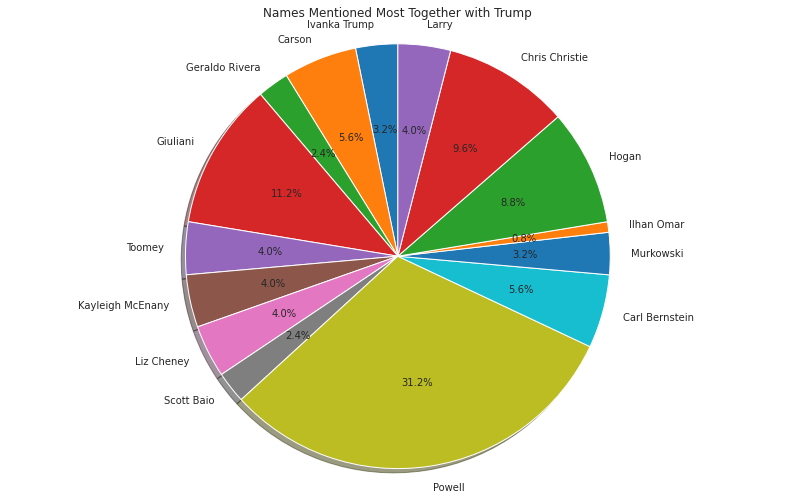

In [17]:
plot_pie_chart(with_trump, title="Names Mentioned Most Together with Trump")

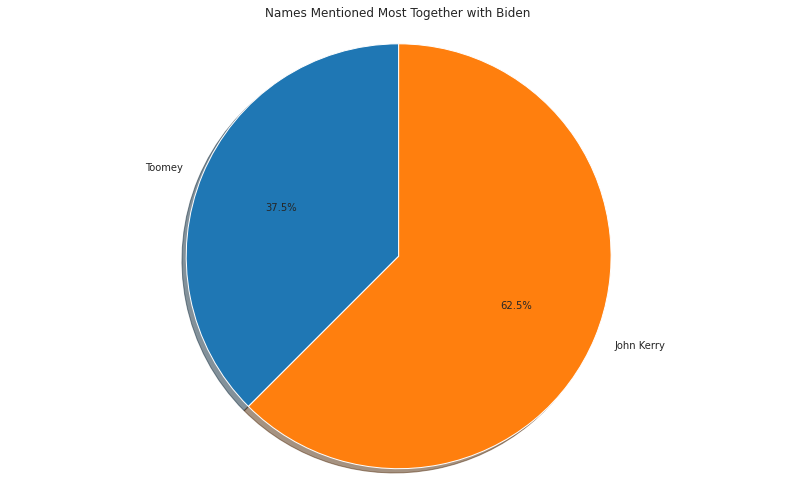

In [18]:
plot_pie_chart(with_biden, title="Names Mentioned Most Together with Biden")

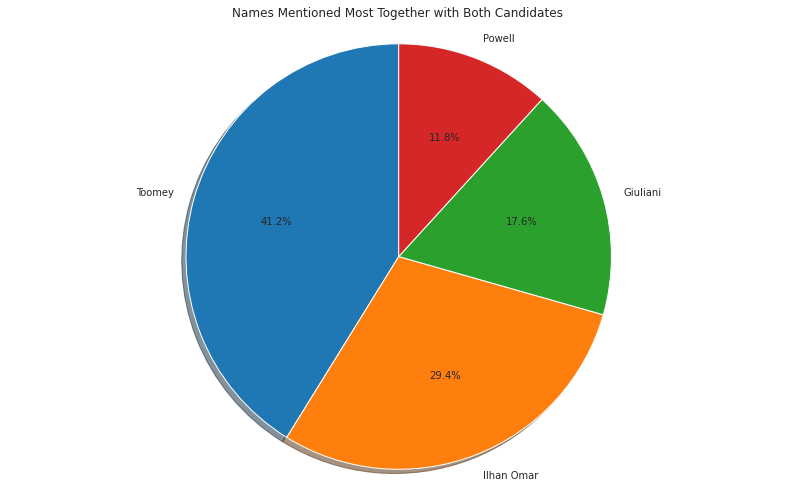

In [19]:
plot_pie_chart(with_both, title="Names Mentioned Most Together with Both Candidates")

In [20]:
loc_with_trump, loc_with_biden, loc_with_both = cooccur_names(top_locs2, df_cand)

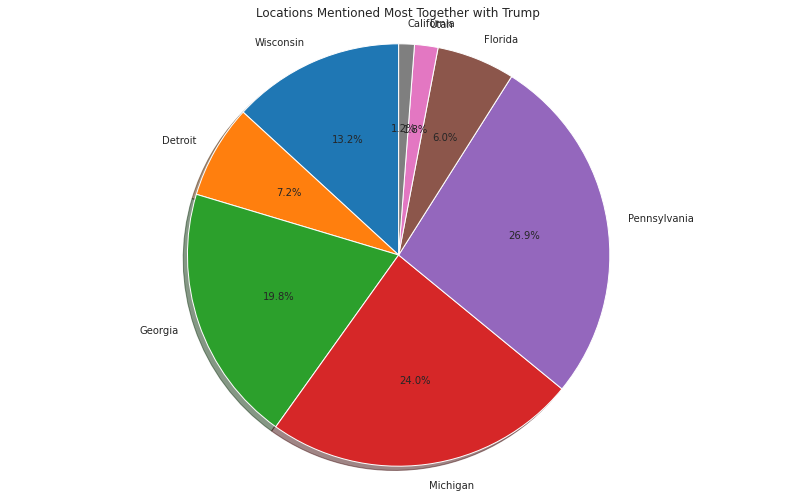

In [21]:
plot_pie_chart(loc_with_trump, title="Locations Mentioned Most Together with Trump")

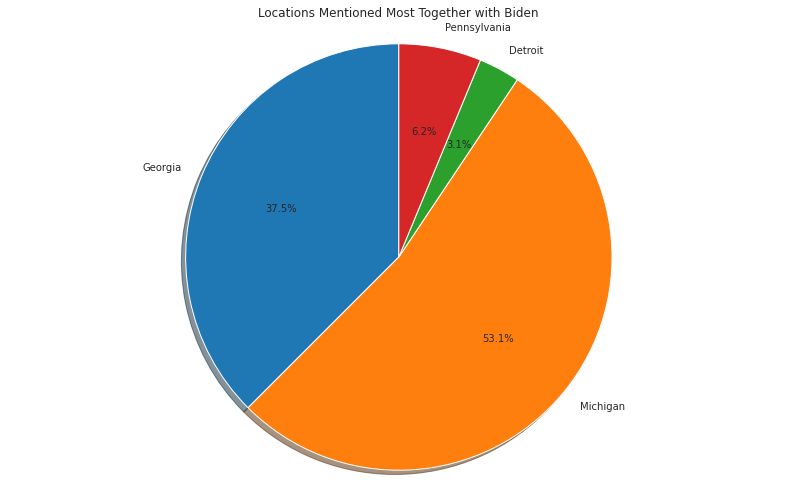

In [22]:
plot_pie_chart(loc_with_biden, title="Locations Mentioned Most Together with Biden")

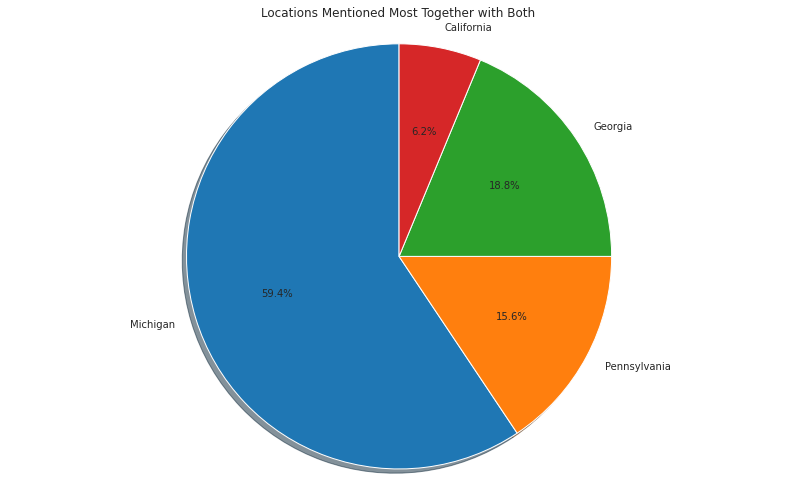

In [23]:
plot_pie_chart(loc_with_both, title="Locations Mentioned Most Together with Both")

**The following names/locations we need to pay extra attention:**

In [24]:
top_names3 = ['Trump', 'Biden', 'Powell', 'Giuliani', 'Hogan', 'Chris Christie', 'Toomey']
top_locs3 = ['Michigan', 'Pennsylvania', 'Georgia']

## 3. Name-topic relevance

In [25]:
topic_count_for_top_names, title_for_top_names = name_topic_corr(top_names3, df_cand)
topic_count_for_top_locs, title_for_top_locs = name_topic_corr(top_locs3, df_cand)

In [26]:
pd.DataFrame(topic_count_for_top_names)

,Trump,Biden,Giuliani,Toomey,Powell,Hogan,Chris Christie
N,32,4,NaN,NaN,NaN,NaN,NaN
I,400,198,14.0,1.0,29.0,11.0,10.0
S,197,33,3.0,NaN,10.0,NaN,1.0
L,141,98,NaN,14.0,2.0,NaN,1.0


In [27]:
pd.DataFrame(topic_count_for_top_locs)

,Georgia,Michigan,Pennsylvania
S,22,25,21
I,7,6,10
L,16,44,20
N,6,1,1


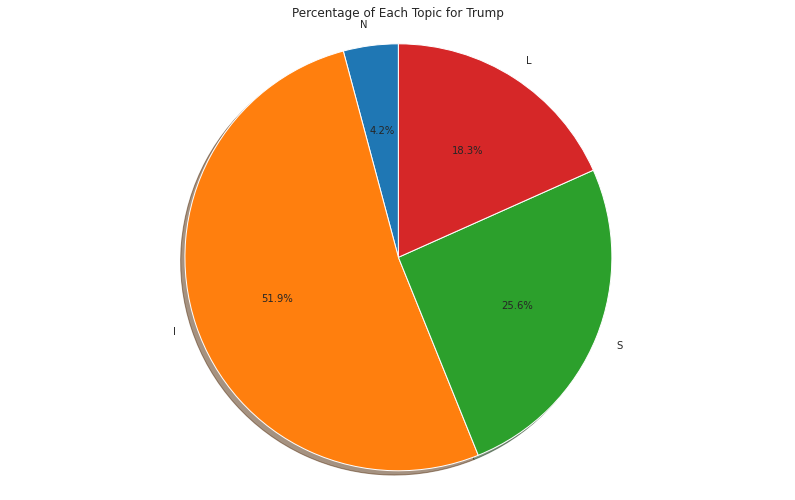

In [28]:
plot_pie_chart(topic_count_for_top_names['Trump'], 'Percentage of Each Topic for Trump')

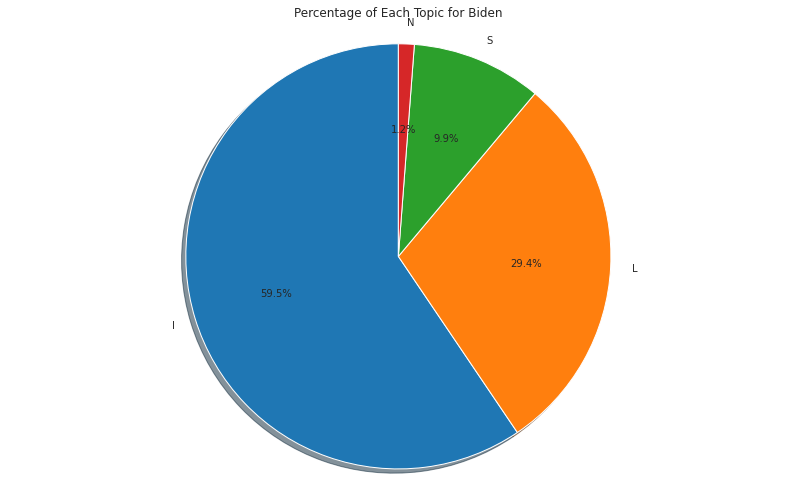

In [29]:
plot_pie_chart(topic_count_for_top_names['Biden'], 'Percentage of Each Topic for Biden')

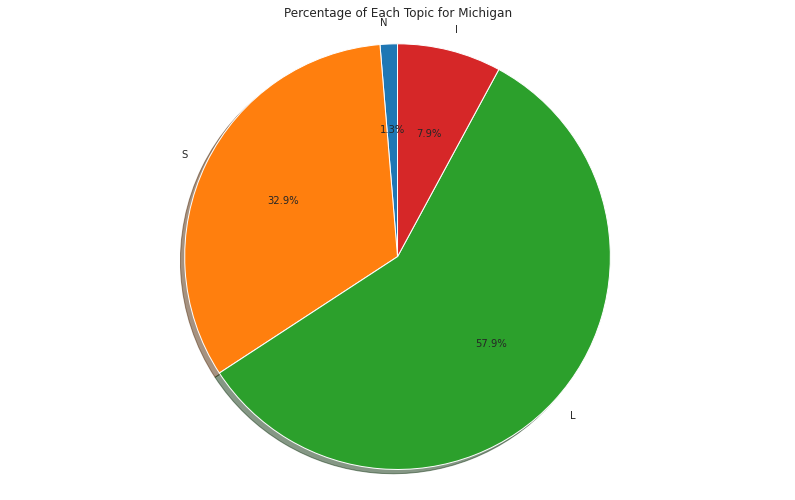

In [30]:
plot_pie_chart(topic_count_for_top_locs['Michigan'], 'Percentage of Each Topic for Michigan')

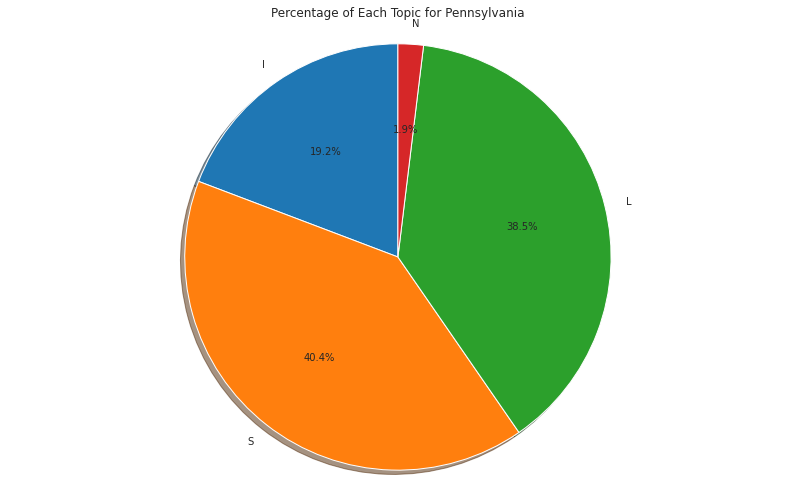

In [31]:
plot_pie_chart(topic_count_for_top_locs['Pennsylvania'], 'Percentage of Each Topic for Pennsylvania')

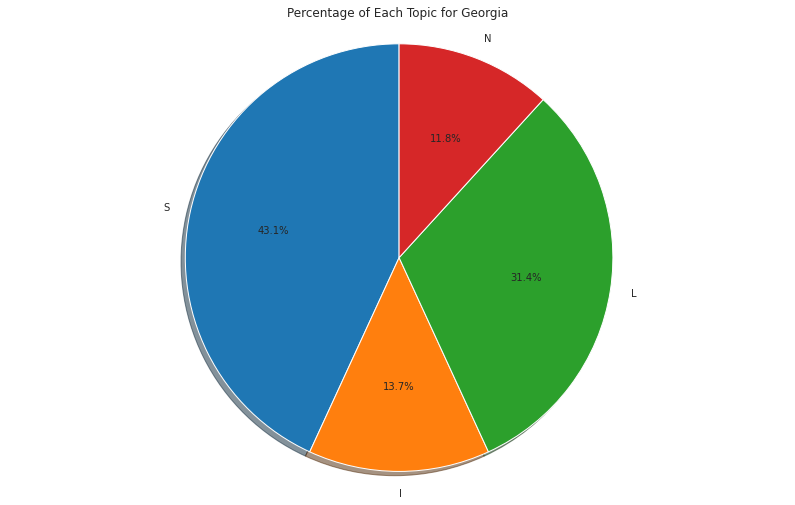

In [32]:
plot_pie_chart(topic_count_for_top_locs['Georgia'], 'Percentage of Each Topic for Georgia')

### So we'd like to know the correlation between each "top name" and each topic

In [33]:
# Perform one-hot encoding for top names
top_name_oh = name_one_hot(top_names3, df_cand)
top_loc_oh = name_one_hot(top_locs3, df_cand)

In [34]:
# Perform one-hot encoding for topics
topic_oh = {k:[1 if row.coding == k else 0 for idx, row in df_cand.iterrows()] for k in df_cand.coding.unique()}

In [35]:
top_name_corr = compute_corr(top_names3, df_cand, topic_oh, top_name_oh)
top_loc_corr = compute_corr(top_locs3, df_cand, topic_oh, top_loc_oh)

In [36]:
top_name_corr1 = {k:pd.Series(v,index=df_cand.coding.unique()) for k, v in top_name_corr.items()}
top_name_corr1 = {k:v.sort_values(ascending=False) for k, v in top_name_corr1.items()}

top_loc_corr1 = {k:pd.Series(v,index=df_cand.coding.unique()) for k, v in top_loc_corr.items()}
top_loc_corr1 = {k:v.sort_values(ascending=False) for k, v in top_loc_corr1.items()}

In [37]:
top_name_corr1['Trump'].index

Index(['S', 'N', 'L', 'I'], dtype='object')

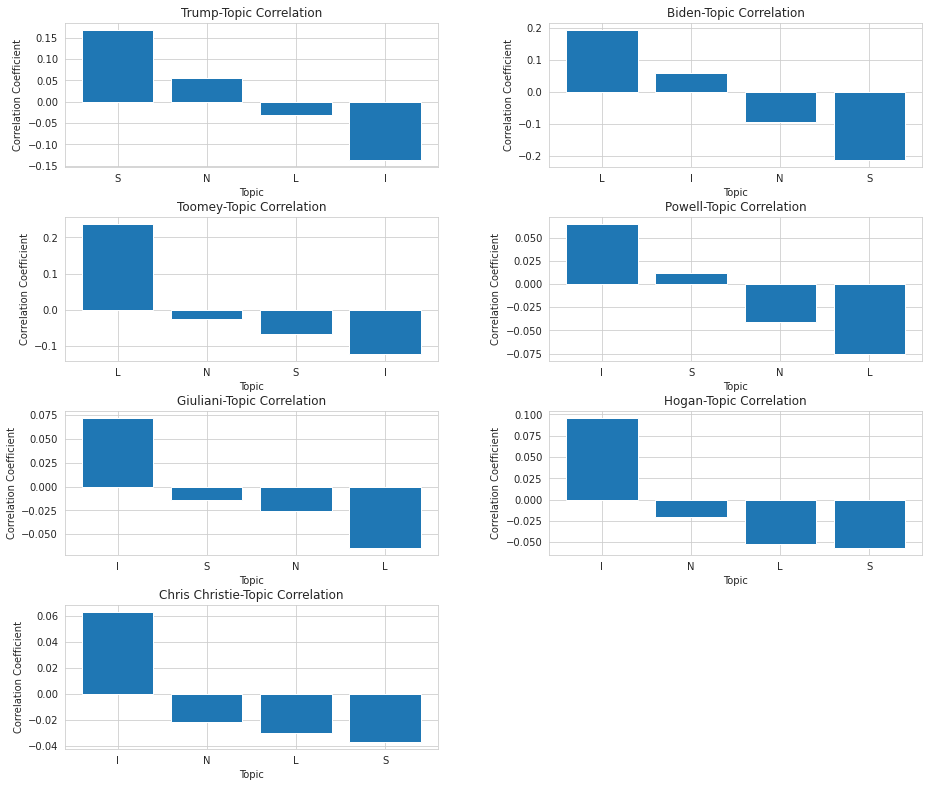

In [38]:
plot_name_correlation(top_name_corr1,'name-topic_correlation.png')

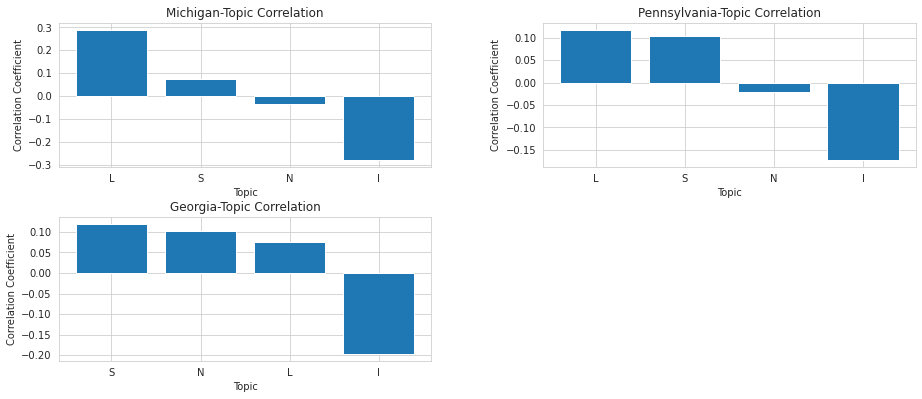

In [39]:
plot_location_correlation(top_loc_corr1,'location-topic_correlation.png')

**Looks like Trump is strongly associated with "Suspicious" and "Not legitimate" events. Biden team has things done legitimately. Toomey is also highly correlated with legal events. So if I didn't know Toomey before, I would have reasonablely inferred that Toomey works for Biden team.**

### Let's see some titles

In [53]:
list(set(title_for_top_locs['Georgia']['S']))

['Trump Camp Outraged Georgia Recount Counted The Votes',
 'Georgia Gov. Kemp Calls for Audit, Says Trump Can Demand New Recount',
 'GOP civil war inspired by Trump grips Georgia, threatens other states',
 '3 ‘dead’ Georgia voters in fact very much alive: Trump, Tucker Carlson get it wrong',
 "Georgia GOP governor says he understands Trump's frustration, but maintains he's following state laws",
 'Pro-Trump Attorney Urges Republicans Not to Vote in Georgia Runoff',
 "Trump Lawyer Says New Lawsuits Will Be Filed in Georgia Soon: 'Quite a Shock'",
 'Pro-Trump Attorney Lin Wood Urges Republicans Not To Vote In Georgia Senate Runoff -- Unless GOP candidates help overturn the presidential election results in the state.',
 "Trump Lawyer Sidney Powell Says Georgia Election Lawsuit 'Will Be Biblical,' Suggests GOP Governor Helped Biden",
 'Trump Supporters in Georgia Threaten to Destroy GOP, Boycott Runoff Elections',
 'Trump Team Files for Fresh Recount in Georgia’s Presidential Race',
 'Over

In [40]:
list(set(title_for_top_names['Giuliani']['I']))

['Trump fears Giuliani, other lawyers in Biden vote challenge are ‘fools that are making him look bad’',
 'Giuliani releases statement distancing Trump campaign from lawyer Sidney Powell',
 "Report of a 'souring' relationship between Trump and Giuliani",
 'Giuliani distances Trump campaign from attorney Sidney Powell',
 "Sidney Powell No Longer Part of Trump's Legal Team: Giuliani Statement",
 'Giuliani, other Trump lawyers to skip meeting with Michigan lawmakers after COVID-19 exposure',
 'Wall Street Journal Bails on Trump’s ‘Conspiracy Theory,’ Says Giuliani is Not a ‘Serious Practicing Attorney',
 'The Two Biggest Losers: Trump and Giuliani — The bigoted New York septuagenarians team up for one last hurrah.',
 'Trump’s lawsuits plagued by spelling errors: ‘I’ve never seen an election lawyer handle a case as poorly as Giuliani has’',
 "Rudy Giuliani's Son Potentially Exposed Most of Trump's Legal Team to COVID During RNC Press Conference",
 'Rudy Giuliani\'s quixotic frenzy has obse

In [41]:
list(set(title_for_top_names['Toomey']['L']))

['Trump has exhausted all plausible legal options: GOP Sen. Pat Toomey congratulates Biden',
 'Release: Toomey Statement on PA Federal Court Decision, Congratulates President-elect Biden | U.S. Senator Pat Toomey of Pennsylvania',
 'Pa. Senator Pat Toomey Says President Trump Has ‘Exhausted All Plausible Legal Options’',
 'Pennsylvania GOP Sen. Toomey Says Trump Should Accept Election Loss',
 '"Trump has exhausted all plausible legal options": GOP Sen. Pat Toomey congratulates Biden',
 'Release: Toomey Statement on PA Federal Court Decision, Congratulates President-elect Biden',
 "Pa. Senator Pat Toomey Says President Trump Has 'Exhausted All Plausible Legal Options'",
 'Pat Toomey: Trump Campaign Has Exhausted Legal Options and Biden Won',
 'Sen. Toomey Congratulates Biden After Pennsylvania Judge Dismisses Trump Lawsuit',
 'Sen. Toomey congratulates Biden as president-elect after judge rules against Trump in Pa.',
 'Pa. Sen. Toomey congratulates President-elect Joe Biden, calls on Tr

In [42]:
list(set(title_for_top_names['Powell']['I']))

['Mike Flynn Jr. adds twist to Trump team’s statement on Sidney Powell: ‘Give this the 24hr rule …’',
 'Trump’s legal team’s statement on Sydney Powell was made to focus on the upcoming Supreme Court case. There are two separate legal pathways. One on equal protection and PA voting rules (most important right now). The second is Dominion soft',
 "Trump Lawyer Sidney Powell Promises 'Biblical' Lawsuit in Coming Days",
 'Rush Limbaugh Does Full 180, Blasts Sidney Powell After Team Trump Disavowed Her',
 'Sidney Powell responds to Trump Campaign legal statement with agreement but an “epic” lawsuit is still coming this week',
 "Trump campaign says Sidney Powell isn't a member of its legal team",
 'Trump campaign purges conspiracy-theorist Sidney Powell from legal team',
 "Trump dumps Sydney Powell, lawyer who promised to ''''blow up'''' Georgia, as legal strategy unravels",
 'Giuliani distances Trump campaign from attorney Sidney Powell',
 "Sidney Powell No Longer Part of Trump's Legal Tea

In [43]:
list(set(title_for_top_names['Powell']['S']))

['Trump’s Legal Team Tries (and Fails) to Disavow Conspiracy Theorist Attorney Sidney Powell: Unfortunately for Rudy Giuliani, Jenna Ellis, and the GOP, it’s not so easy to un-release The Kraken',
 'Sidney Powell Confirms Non-Affiliation With Trump Legal Team, Vows to Continue Fraud Fight',
 'Watch: Sidney Powell – Millions of DEAD People Voted! 7 Million Votes STOLEN From Trump!',
 "Trump Lawyer Sidney Powell Says Georgia Election Lawsuit 'Will Be Biblical,' Suggests GOP Governor Helped Biden",
 'Trump dumps Sydney Powell, lawyer who promised to "blow up" Georgia, as legal strategy unravels',
 'Trump campaign cuts Sidney Powell from president’s legal team - The abrupt shake-up comes as Powell makes far-fetched and unsupported claims of voter fraud in the 2020 elections.',
 "Trump campaign says Sidney Powell isn't a member of its legal team",
 "Tucker Carlson\u200b says Trump attorney Sidney Powell wouldn't provide him with any evidence of election fraud. Powell hits back.",
 'Trump Fi

In [44]:
list(set(title_for_top_names['Hogan']['I']))

['‘Stop golfing and concede’: Trump and Maryland Gov. Hogan spar again after president criticizes South Korean tests',
 'GOP Governor On Trump\'s Election Tantrum: Beginning To Look Like A \'Banana Republic\' - "Frankly, I\'m embarrassed that more people in the party aren’t speaking up," Maryland Gov. Larry Hogan said.',
 "Hogan ramps up criticism of Trump: 'Stop golfing and concede'",
 "Hogan 'embarrassed that more people' in the GOP 'aren't speaking up' against Trump",
 '‘Stop Golfing And Concede’ | Gov. Larry Hogan Hits Back At President Trump’s Tweet On South Korea COVID-19 Tests',
 "'Stop golfing and concede': Gov. Hogan fires back on Pres. Trump's COVID test claims",
 'Stop golfing and concede: Maryland GOP Governor Larry Hogan spars with Trump',
 "Republican Gov. Larry Hogan is 'embarrassed that more people in the party aren't speaking up' against Trump's refusal to concede",
 "Hogan: Trump making US look like a 'banana republic'",
 "Larry Hogan to Trump: 'Stop golfing and conce

In [45]:
list(set(title_for_top_names['Chris Christie']['I']))

["Chris Christie calls Trump's legal team a 'national embarrassment'",
 'Chris Christie calls the conduct of Trump’s legal team a ‘national embarrassment’',
 "Chris Christie rips Trump's legal team as ‘national embarrassment’",
 'Trump ally, former NJ governor Chris Christie: president’s election fraud claims are a ‘national embarrassment’',
 "Chris Christie: Trump's legal team 'a national embarrassment'",
 "Chris Christie Says Trump's Legal Team Has Become a 'National Embarrassment'",
 "Chris Christie Tears Into Trump's Legal Team: 'A National Embarrassment'",
 'Chris Christie: Trump’s Legal Team Has Been a ‘National Embarrassment’',
 "Chris Christie Calls Trump Legal Team ‘National Embarrassment,' Tells President to End Election Suits",
 "Chris Christie dismissed Trump's legal team as 'a national embarrassment'"]

In [46]:
[print(idx, list(set(title_for_top_names['Trump']['L']))[idx]) for idx in range(20)]

0 CNN's Brianna Keilar rolls the tape on Donald Trump's history of baselessly claiming election fraud
1 Chris Christie calls Trump's legal team a 'national embarrassment'
2 Trump Administration To Start Transition Process For Biden
3 Trump friend and adviser Steve Schwarzman recognizes Biden as President-elect
4 Michigan Certifies Election Results, Declaring Biden Winner In New Blow To Trump
5 Federal judge rejects Trump campaign's Pa. lawsuit with prejudice, saying it lacks factual proof
6 Georgia Gov. Kemp Calls for Audit, Says Trump Can Demand New Recount
7 Trump accepts transition to Biden can begin
8 Michigan certifies Biden win despite Trump's GOP overtures
9 Latest: Why a Federal Judge Tossed Out One of the Trump Campaign's PA Lawsuits
10 Judge slaps down Trump appointee who has sought to reshape Voice of America and related agencies
11 Biden's margin of victory over Trump surpasses 6 million votes
12 In 'Tremendous Rebuke' of Trump Appointee, Federal Judge Bars US Media Agency 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [47]:
[print(idx, list(set(title_for_top_names['Trump']['N']))[idx]) for idx in range(20)]

0 Trump urges state legislatures and courts to ‘flip’ results
1 Trump Requests Georgia Recount, Meaning 5 Million Votes Will Be Tabulated A 3rd Time
2 Trump appeals rejection of effort to block Pennsylvania vote
3 Wisconsin officials: Trump observers obstructing recount | Election officials overseeing the recount of presidential votes in Wisconsin’s largest county are accusing observers for President Donald Trump of unduly slowing the process
4 Trump Campaign Formally Requests a Recount in Georgia
5 Threats to Election Officials Piled Up as President Trump Refused to Concede
6 Detroit voters sue President Trump over his attempt to block certification of election results
7 'Unacceptable': Wisconsin Election Officials Say Trump Observers Hindering Recount With Constant Interruptions, Questions
8 Wisconsin Officials: Trump Observers Obstructing Recount
9 A Republican judge just tore into Trump’s election lawyers for their incompetence. Trump’s lawyers asked a judge to disenfranchise nearl

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [48]:
[print(idx, list(set(title_for_top_names['Trump']['I']))[idx]) for idx in range(20)]

0 Barack Obama on a Biden presidency, racism in the Trump era and what he misses about being president
1 U.S. Sen. Marsha Blackburn, a Trump ally, refers to Biden as 'president-elect'
2 Trump lifts travel ban on Chad
3 Trump team making false argument about his 2016 transition
4 Pennsylvania’s Lt. Gov. Trolls Trump, ‘Dopey’ GOP Lawsuits In Epic Tweetstorm
5 Dominion responds to Trump team claims
6 Chris Christie: Trump's legal team 'a national embarrassment'
7 Trump Orders Hasty Afghanistan, Iraq Drawdowns to Beat Biden Inauguration
8 Obama Tells Jimmy Kimmel: 'We Can Always Send the Navy SEALS' to Remove Trump from White House
9 Two-thirds of GOP voters support Trump running for president in 2024: survey
10 Chris Christie calls the conduct of Trump’s legal team a ‘national embarrassment’
11 Voice of America's 5 Months Under Trump CEO: Lawsuits, Bias Claims, And A Sex Scandal
12 Former Ohio Gov. John Kasich Says GOP Is 'Afraid' Of Trump
13 Impeach the president again — Removal from off

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [49]:
def search_for_keywords()




[print(idx, list(set(title_for_top_names['Trump']['L']))[idx]) for idx in range(len(list(set(title_for_top_names['Trump']['L'])))) if 'Toomey' in list(set(title_for_top_names['Trump']['L']))[idx]]

SyntaxError: invalid syntax (<ipython-input-49-e368129712c3>, line 1)

In [ ]:
[print(idx, list(set(title_for_top_names['Trump']['S']))[idx]) for idx in range(len(list(set(title_for_top_names['Trump']['S'])))) if 'fraud' in list(set(title_for_top_names['Trump']['S']))[idx]]